In [135]:
from cnn import main_model
from cnn import residual_model
from importlib import reload
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from data import augmentation
import numpy as np
import datetime
import os
import pickle
from PIL import Image
torch.manual_seed(42)

In [100]:
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [26]:
# augmentation
import data
reload(data.augmentation)
images = augmentation.augment('data/raw_images/chords', 'data/extracted_chords/augmented', class_labels)

In [94]:
transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor()
])

# Create a dataset from image folder
dataset = ImageFolder(root='data/extracted_chords/augmented', transform=transform)

# Define the proportions for train, val, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the sizes of each subset based on the ratios
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Randomly split the dataset into train, val, and test subsets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for each subset
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [82]:
num_classes = 7
learning_rate = 0.02
hidden_layers = [128, 512, 512, 512, 512, 512]

In [95]:
import cnn
reload(cnn.main_model)
reload(cnn.residual_model)
from cnn import model
from cnn import residual_model

model = main_model.CnnChordClassifier(num_classes, hidden_layers)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [92]:
# model = torch.load('saved_models/bestmodel_5_layers_no_skip.pth/bestmodel_epoch_34.pth')
# model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [96]:
# Train the model
start_time = datetime.datetime.now().strftime("%m.%d_%H.%M.%S")
save_path = f'saved_models/{start_time}'
print(f'{start_time} --- Training started')
val_history = []
loss_history = []
num_epochs = 100
best_valid_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # loss and evaluation after each epoch
    model.eval()
    valid_accuracy = 0.0
    valid_samples = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            valid_accuracy += (predicted == labels).sum().item()
            valid_samples += labels.size(0)
    
    valid_accuracy /= valid_samples
    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    val_history.append(valid_accuracy)
    print('{} --- Epoch [{}/{}], Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(
        datetime.datetime.now().strftime("%m.%d_%H:%M:%S"), epoch+1, num_epochs, avg_loss, valid_accuracy * 100))
    
    # Check if current model has the best validation accuracy
    if valid_accuracy > best_valid_accuracy:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        best_valid_accuracy = valid_accuracy
        torch.save(model, f'{save_path}/bestmodel.pth')

with open(f'{save_path}/loss_history.pkl', 'wb') as f:
    pickle.dump(loss_history, f)
with open(f'{save_path}/val_history.pkl', 'wb') as f:
    pickle.dump(val_history, f)

07.16_10.29.55 --- Training started
07.16_10:30:08 --- Epoch [1/100], Loss: 2.1566, Validation Accuracy: 24.78%
07.16_10:30:19 --- Epoch [2/100], Loss: 1.6467, Validation Accuracy: 28.99%
07.16_10:30:31 --- Epoch [3/100], Loss: 1.3108, Validation Accuracy: 50.65%
07.16_10:30:42 --- Epoch [4/100], Loss: 1.0171, Validation Accuracy: 51.30%
07.16_10:30:53 --- Epoch [5/100], Loss: 0.8200, Validation Accuracy: 57.75%
07.16_10:31:04 --- Epoch [6/100], Loss: 0.6582, Validation Accuracy: 55.36%
07.16_10:31:15 --- Epoch [7/100], Loss: 0.5368, Validation Accuracy: 70.00%
07.16_10:31:26 --- Epoch [8/100], Loss: 0.4573, Validation Accuracy: 83.12%
07.16_10:31:37 --- Epoch [9/100], Loss: 0.3898, Validation Accuracy: 65.36%
07.16_10:31:48 --- Epoch [10/100], Loss: 0.3320, Validation Accuracy: 82.54%
07.16_10:31:59 --- Epoch [11/100], Loss: 0.2864, Validation Accuracy: 93.99%
07.16_10:32:10 --- Epoch [12/100], Loss: 0.2429, Validation Accuracy: 82.32%
07.16_10:32:21 --- Epoch [13/100], Loss: 0.2125, 

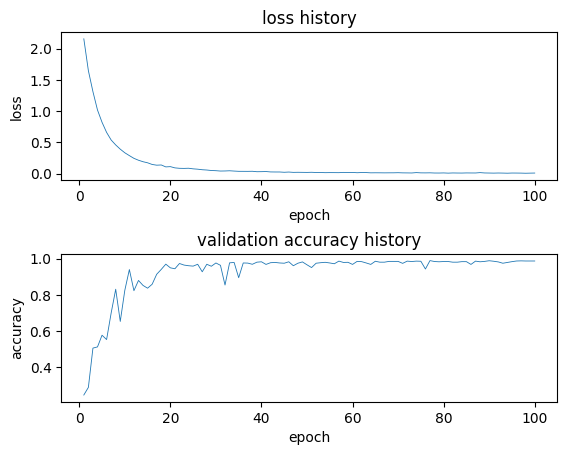

In [126]:
import matplotlib.pyplot as plt

path = f'saved_models/no_skip_connections_80_80__07.16_10.29.55'

loss = pickle.load(open(f'{path}/loss_history.pkl', 'rb'))
val = pickle.load(open(f'{path}/val_history.pkl', 'rb'))

fig, axs = plt.subplots(2)

axs[0].set_title('loss history')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].plot(range(1, len(loss)+1), loss, linewidth=0.6)

axs[1].set_title('validation accuracy history')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(1, len(val)+1), val, linewidth=0.6)

plt.subplots_adjust(hspace=0.5)

Test accuracy: 0.9746376811594203
Here are the wrong predicitons:


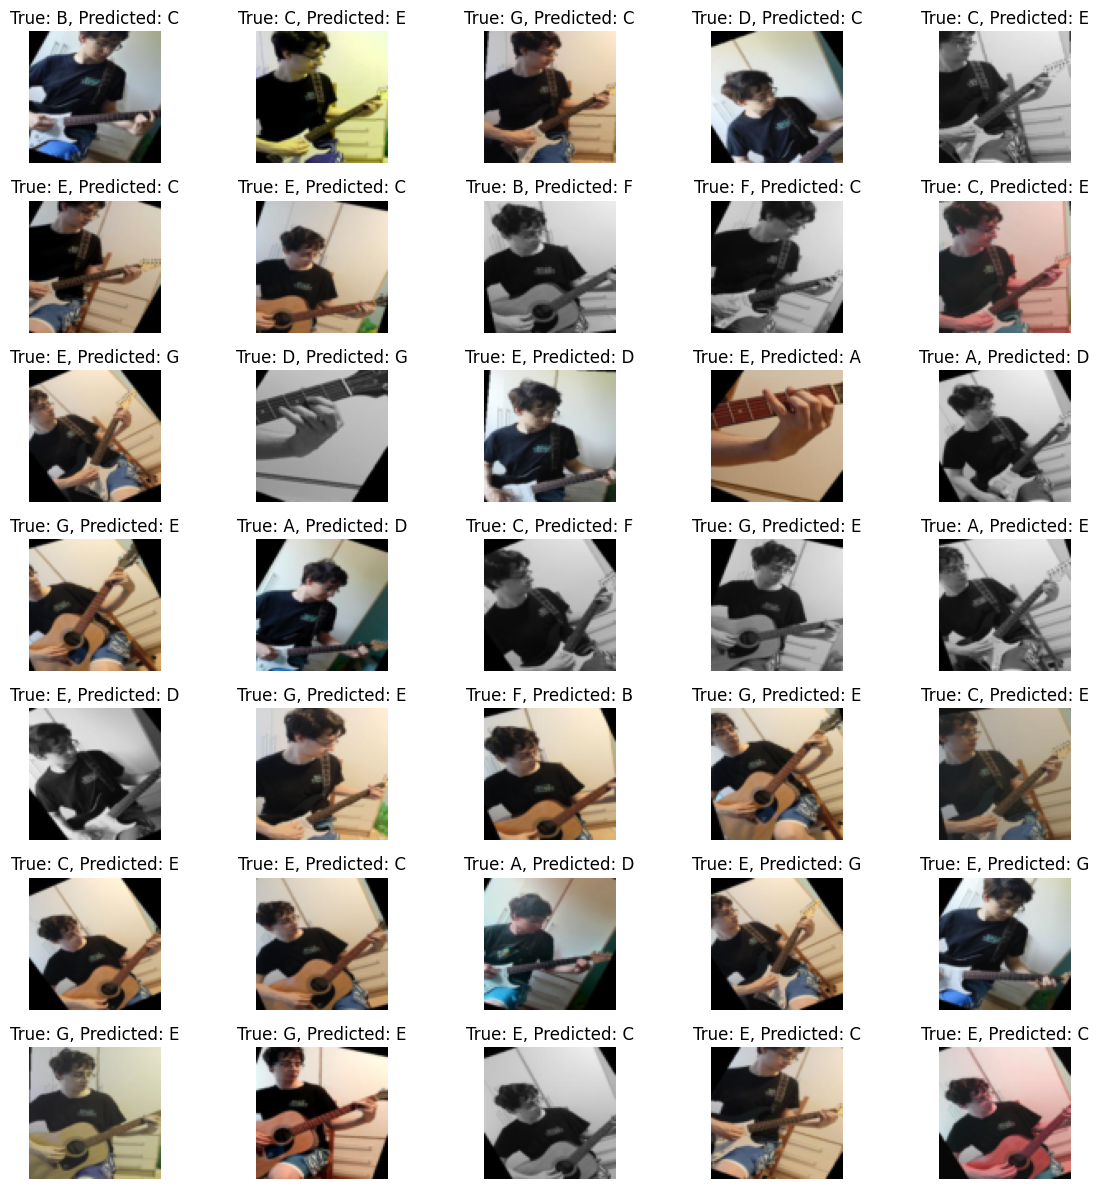

0.9746376811594203

In [120]:
from cnn import evaluation
reload(evaluation)

evaluation.evaluate(model, test_loader, device, class_labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted: F


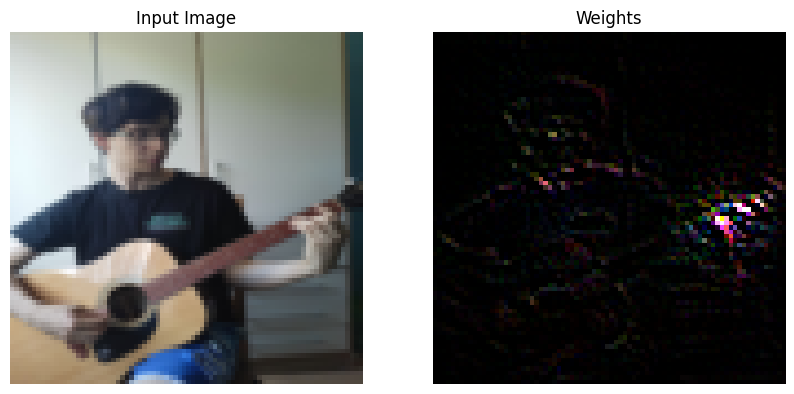

In [266]:
from cnn import visualize_target
reload(visualize_target)

image = Image.open('data/raw_images/chords/F/far.jpg')
image = transform(image)
image = image.to(device)
target_layer = model.conv1
visualize_target.visualize(model, target_layer, image, class_labels)